In this lab, we'll be working with a dataset from Kaggle that contains time series data for Bitcoin and other digital currencies. This data was prepared using the Alpha Vantage API and is well-suited for exploring time-based modeling.

**Dataset Download:**  
[Digital Currency Time Series (Kaggle)](https://www.kaggle.com/datasets/ahmedadam415/digital-currency-time-series?resource=download)


## Primary Goal

- Predict daily Bitcoin stock using time series data.


## Assignment Specifications

- You must explore multiple **Recurrent Neural Network (RNN)** models to solve this prediction problem.
- The dataset includes multiple time series. You may choose which one you want to focus on (e.g., Bitcoin, Ethereum).
- Your submission should be written for a **non-expert audience**:
  - Narrate your code and decisions using accessible language.
  - Avoid technical jargon unless it is clearly explained.
- Include all relevant code, but prioritize clarity and communication in your notebook.

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import tensorflow as tf
import random
import os

def set_seeds(seed=42):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

## Dataset Introduction

The dataset used in this analysis contains historical time series data for various digital currencies, including Bitcoin, sourced via the Alpha Vantage API and made available on Kaggle. Each record includes daily trading metrics such as open, high, low, close prices, trading volume, and market capitalization for each currency, identified by timestamps.



In [2]:
url = "https://raw.githubusercontent.com/bellamccarty/GSB-545/refs/heads/main/Lab05/Data/dc.csv"
df = pd.read_csv(url)
df.head()

,Unnamed: 0,open_SAR,open_USD,high_SAR,high_USD,low_SAR,low_USD,close_SAR,close_USD,volume
0,2021-01-30,128437.248512,34246.28,131012.723200,34933.00,123106.880000,32825.00,128333.212416,34218.54,43072
1,2021-01-29,125144.022272,33368.18,144510.037760,38531.90,119695.516160,31915.40,128459.450880,34252.20,231827
2,2021-01-28,113870.357376,30362.19,126703.438592,33783.98,111919.811840,29842.10,125131.570944,33364.86,92621
3,2021-01-27,121753.023104,32464.01,122102.860416,32557.29,109668.146688,29241.72,113885.208960,30366.15,95911
4,2021-01-26,120966.114176,32254.19,123470.218752,32921.88,115652.472448,30837.37,121767.124608,32467.77,84972


In [3]:
# Quick overview
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  1000 non-null   object 
 1   open_SAR    1000 non-null   float64
 2   open_USD    1000 non-null   float64
 3   high_SAR    1000 non-null   float64
 4   high_USD    1000 non-null   float64
 5   low_SAR     1000 non-null   float64
 6   low_USD     1000 non-null   float64
 7   close_SAR   1000 non-null   float64
 8   close_USD   1000 non-null   float64
 9   volume      1000 non-null   int64  
dtypes: float64(8), int64(1), object(1)
memory usage: 78.3+ KB


,Unnamed: 0,open_SAR,open_USD,high_SAR,high_USD,low_SAR,low_USD,close_SAR,close_USD,volume
0,2021-01-30,128437.248512,34246.28,131012.723200,34933.00,123106.880000,32825.00,128333.212416,34218.54,43072
1,2021-01-29,125144.022272,33368.18,144510.037760,38531.90,119695.516160,31915.40,128459.450880,34252.20,231827
2,2021-01-28,113870.357376,30362.19,126703.438592,33783.98,111919.811840,29842.10,125131.570944,33364.86,92621
3,2021-01-27,121753.023104,32464.01,122102.860416,32557.29,109668.146688,29241.72,113885.208960,30366.15,95911
4,2021-01-26,120966.114176,32254.19,123470.218752,32921.88,115652.472448,30837.37,121767.124608,32467.77,84972


### Clean Column Names and Parse Dates

The first column appears to be a timestamp. I'll rename it to `date` and convert it to datetime format to facilitate the time series operations.

In [4]:
# Rename and convert date column
df = df.rename(columns={"Unnamed: 0": "date"})
df["date"] = pd.to_datetime(df["date"])

# Sort by date
df = df.sort_values("date").reset_index(drop=True)

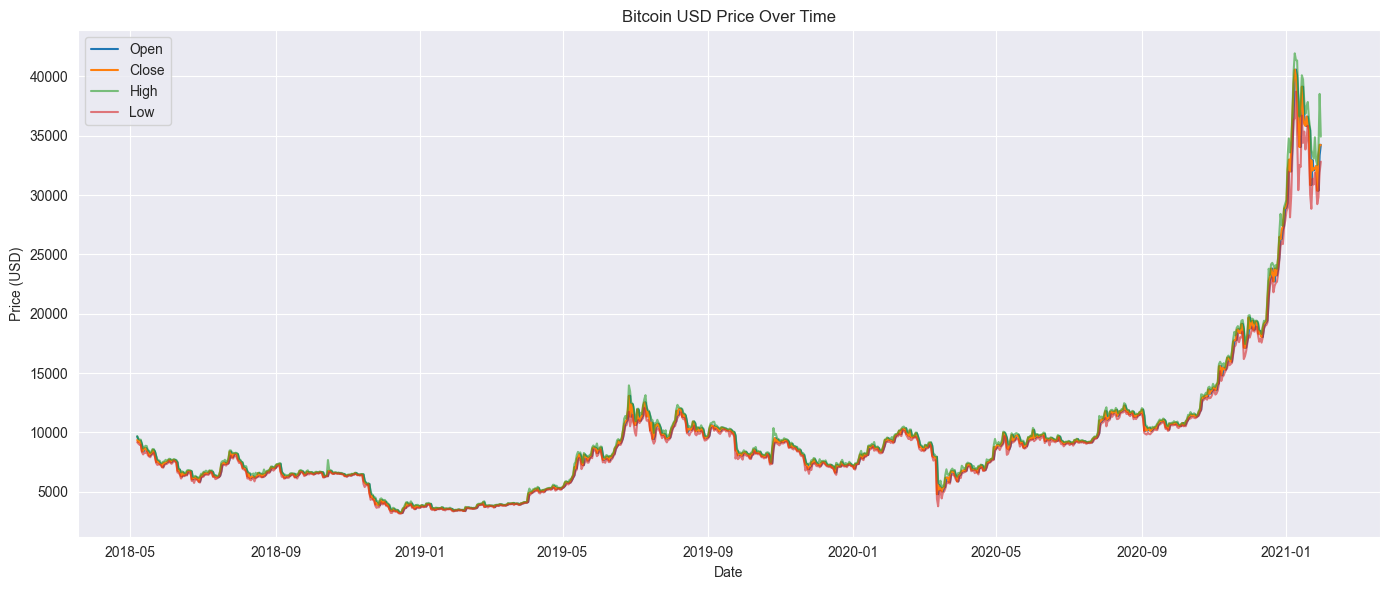

In [5]:
plt.figure(figsize=(14, 6))
plt.plot(df["date"], df["open_USD"], label="Open")
plt.plot(df["date"], df["close_USD"], label="Close")
plt.plot(df["date"], df["high_USD"], label="High", alpha=0.6)
plt.plot(df["date"], df["low_USD"], label="Low", alpha=0.6)
plt.title("Bitcoin USD Price Over Time")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

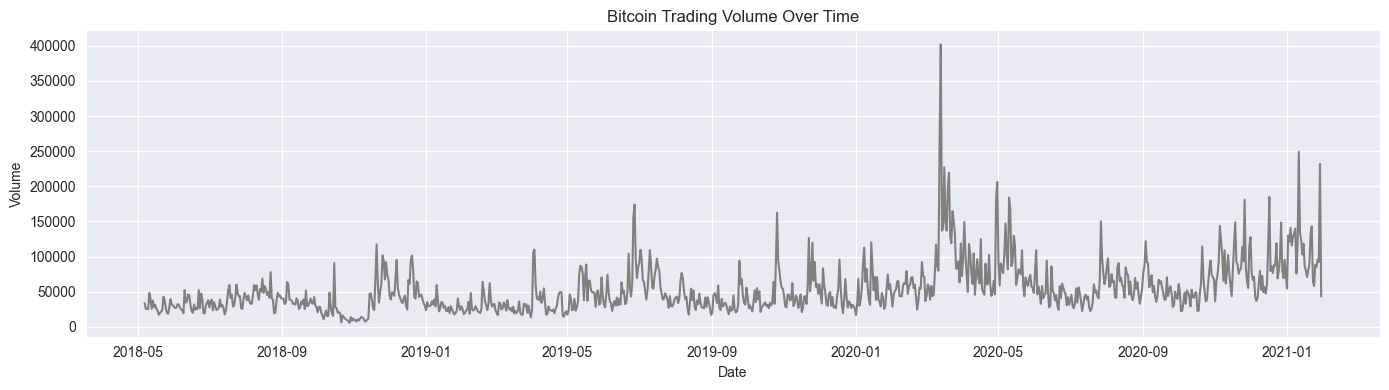

In [6]:
plt.figure(figsize=(14, 4))
plt.plot(df["date"], df["volume"], color="gray")
plt.title("Bitcoin Trading Volume Over Time")
plt.xlabel("Date")
plt.ylabel("Volume")
plt.grid(True)
plt.tight_layout()
plt.show()

#### Price Trends

- Bitcoin prices were relatively stable and low between 2018 and early 2020.
- A noticeable upward trend began in mid-2020, culminating in a sharp surge during late 2020 and early 2021, with Bitcoin surpassing $40,000.
- The high correlation between the open, close, high, and low values indicates relatively consistent daily movement ranges without large intraday anomalies.

#### Volume Trends

- Trading volume fluctuated heavily over the time period, with several extreme spikes (notably around early 2020).
- Volume generally increased during periods of rising prices, particularly during the 2020 bull market. This supports the idea that price and volume are often positively correlated in speculative markets like cryptocurrency.

## Modeling

### Preparing the Bitcoin Price Data for Modeling

Before training the models, I needed to carefully prepare the data so it could be understood by time-based learning algorithms like RNNs and LSTMs. This involved a few key steps, each designed to help the model recognize patterns in how Bitcoin prices move over time.

#### 1. Scaling the Data

I began by rescaling the Bitcoin closing price to a range between 0 and 1. This step helps the model learn more efficiently by keeping all values on the same scale. Without this, large numbers could overwhelm the learning process.

#### 2. Splitting the Data

Next, I divided the data into two parts:
- **Training data** (the first 80%) – used to teach the model
- **Testing data** (the last 20%) – used to see how well the model performs on new, unseen data

This split helps simulate how a real forecasting model would behave: it learns from the past, then makes predictions about the future.

#### 3. Creating Sliding Windows

Since the models predict the next day's price based on previous days, I used a technique called a "sliding window." This means I feed the model a set number of days (like 10 days in a row) and ask it to predict the price on the next day. I repeat this process across the entire dataset to create many training examples.

#### 4. Formatting the Data for the Model

Finally, I reshaped the data into a structure the model can understand , essentially a stack of daily price windows, ready to be processed one sequence at a time.

In [7]:
from sklearn.preprocessing import MinMaxScaler

def scale_series(series):
    """
    Scales a single-column DataFrame using MinMaxScaler.

    Returns the scaled array and the fitted scaler.
    """
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(series)
    return scaled, scaler

def split_time_series(data, train_ratio=0.8):
    """
    Splits time series array into train/test sets.
    """
    train_size = int(len(data) * train_ratio)
    train = data[:train_size]
    test = data[train_size:]
    return train, test

def create_dataset(dataset, look_back=1):
    """
    Creates sequences of lagged inputs and next-step targets.
    """
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        dataX.append(dataset[i:(i + look_back), 0])
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

def reshape_for_rnn(X):
    """
    Reshapes array to fit RNN/LSTM input: (samples, timesteps, features)
    """
    return np.reshape(X, (X.shape[0], X.shape[1], 1))

In [8]:
# Select and scale the target variable
btc = df[["close_USD"]]
btc_scaled, btc_scaler = scale_series(btc)

# Split
train, test = split_time_series(btc_scaled, train_ratio=0.8)

### Building and Testing Forecasting Models

Once the data was ready, I built two types of models to predict the next day’s Bitcoin closing price:

- A **Simple Recurrent Neural Network (RNN)**
- A **Long Short-Term Memory (LSTM)** network, which is a more powerful and memory-efficient type of RNN

Both models are designed to learn from sequences of data , in the case, windows of past Bitcoin prices , and make forecasts about what comes next.

### How the Models Were Built

Each model has three key layers:

1. A recurrent layer (`SimpleRNN` or `LSTM`) that processes time-based data and learns trends.
2. A dropout layer that helps prevent overfitting by randomly ignoring some of the learned connections during training.
3. A final dense layer that produces a single prediction , the next day’s price.


In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import GlorotUniform

def build_rnn_model(input_shape, units=50, dropout=0.2, seed=42):
    """
    Builds a SimpleRNN model with specified units and dropout.
    """
    model = Sequential([
        SimpleRNN(units, activation='tanh',
                  input_shape=input_shape,
                  kernel_initializer=GlorotUniform(seed=seed)),
        Dropout(dropout),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def build_lstm_model(input_shape, units=50, dropout=0.2, seed=42):
    """
    Builds an LSTM model with specified units and dropout.
    """
    model = Sequential([
        LSTM(units, activation='tanh',
             input_shape=input_shape,
             kernel_initializer=GlorotUniform(seed=seed)),
        Dropout(dropout),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

### Testing Many Combinations

Running a **grid search**, means I tested many versions of each model by changing:

- The **look-back window** (how many days of past data the model uses)
- The number of **hidden units** (how much memory the model has)
- The **dropout rate** (how aggressively I prevent overfitting)

For each combination, the model was trained on the training data and tested on the unseen test set. I used a technique called **early stopping** so that training would automatically stop if the model wasn’t improving, helping to save time and prevent overfitting.

### How I Measured Success

Evaluating each model’s performance using Mean Squared Error (MSE) means looking for lower values. This means the model’s predictions were closer to the actual prices. The results were collected into a table so I could compare which combinations worked best.


In [10]:
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error

def run_grid_search(train, test, param_grid, build_model_fn, model_name="LSTM"):
    """
    Performs a grid search over look_back, units, and dropout for a given model builder.

    Parameters:
        - train, test: np.array of scaled data
        - param_grid: dict with keys 'look_back', 'units', 'dropout'
        - build_model_fn: function that returns a compiled Keras model
        - model_name: string identifier to label the results ('LSTM' or 'RNN')

    Returns:
        - results_df: DataFrame with all combinations and their validation MSE
    """
    results = []

    for look_back in param_grid['look_back']:
        trainX, trainY = create_dataset(train, look_back)
        testX, testY = create_dataset(test, look_back)

        trainX = reshape_for_rnn(trainX)
        testX = reshape_for_rnn(testX)

        for units in param_grid['units']:
            for dropout in param_grid['dropout']:
                model = build_model_fn((look_back, 1), units=units, dropout=dropout)

                history = model.fit(
                    trainX, trainY,
                    validation_data=(testX, testY),
                    epochs=30,
                    batch_size=32,
                    verbose=0,
                    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)]
                )

                preds = model.predict(testX, verbose=0)
                mse = mean_squared_error(testY, preds)

                results.append({
                    'model': model_name,
                    'look_back': look_back,
                    'units': units,
                    'dropout': dropout,
                    'val_mse': mse
                })

    return pd.DataFrame(results).sort_values(by="val_mse")

## LSTM

In [11]:
set_seeds(42)

param_grid = {
    'look_back': [10, 20, 30],
    'units': [50, 64],
    'dropout': [0.2, 0.3]
}

lstm_results_df = run_grid_search(train, test, param_grid, build_model_fn=build_lstm_model, model_name="LSTM")

C:\Users\isabe\PycharmProjects\GSB-545\downgradedenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\isabe\PycharmProjects\GSB-545\downgradedenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\isabe\PycharmProjects\GSB-545\downgradedenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


C:\Users\isabe\PycharmProjects\GSB-545\downgradedenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


C:\Users\isabe\PycharmProjects\GSB-545\downgradedenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\isabe\PycharmProjects\GSB-545\downgradedenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\isabe\PycharmProjects\GSB-545\downgradedenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\isabe\PycharmProjects\GSB-545\downgraded

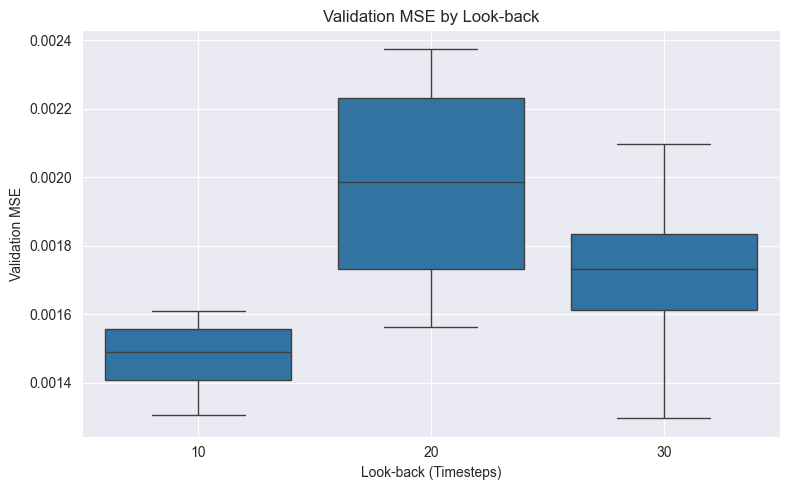

In [12]:
lstm_results_df = lstm_results_df.sort_values(by="val_mse")

plt.figure(figsize=(8, 5))
sns.boxplot(data=lstm_results_df, x='look_back', y='val_mse')
plt.title("Validation MSE by Look-back")
plt.xlabel("Look-back (Timesteps)")
plt.ylabel("Validation MSE")
plt.grid(True)
plt.tight_layout()
plt.show()

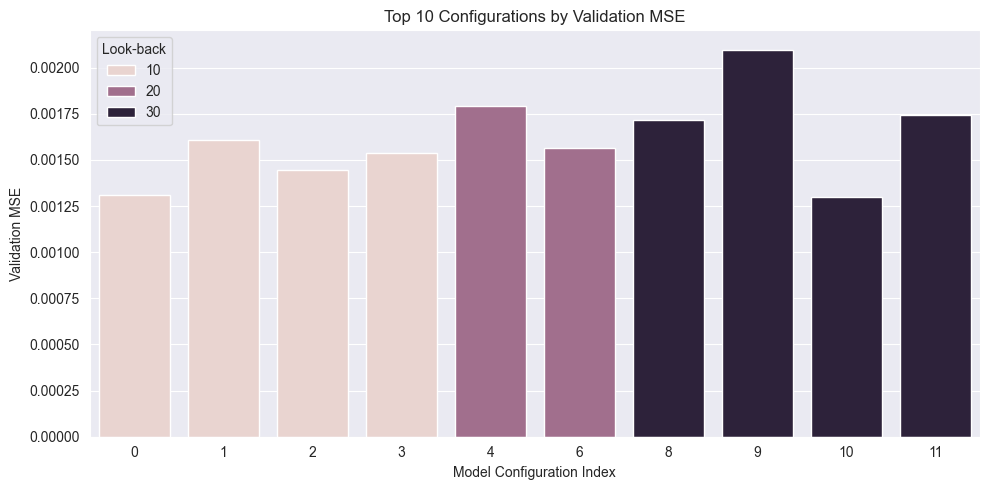

In [13]:
top10 = lstm_results_df.sort_values("val_mse").head(10)

plt.figure(figsize=(10, 5))
sns.barplot(data=top10, x=top10.index, y='val_mse', hue='look_back')
plt.title("Top 10 Configurations by Validation MSE")
plt.xlabel("Model Configuration Index")
plt.ylabel("Validation MSE")
plt.legend(title='Look-back')
plt.tight_layout()
plt.show()

In [14]:
best_config = lstm_results_df.sort_values(by='val_mse').iloc[0]
print("Best config:\n", best_config)

Best config:
 model            LSTM
look_back          30
units              64
dropout           0.2
val_mse      0.001297
Name: 10, dtype: object


In [15]:
# Recreate dataset for best look_back
best_look_back = int(best_config['look_back'])
trainX, trainY = create_dataset(train, best_look_back)
testX, testY = create_dataset(test, best_look_back)

trainX = reshape_for_rnn(trainX)
testX = reshape_for_rnn(testX)

In [16]:
# Retrain the best model
best_model = build_lstm_model(
    input_shape=(best_look_back, 1),
    units=int(best_config['units']),
    dropout=float(best_config['dropout'])
)

best_model.fit(
    trainX, trainY,
    validation_data=(testX, testY),
    epochs=30,
    batch_size=32,
    verbose=0,
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)]
)

preds = best_model.predict(testX)

C:\Users\isabe\PycharmProjects\GSB-545\downgradedenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


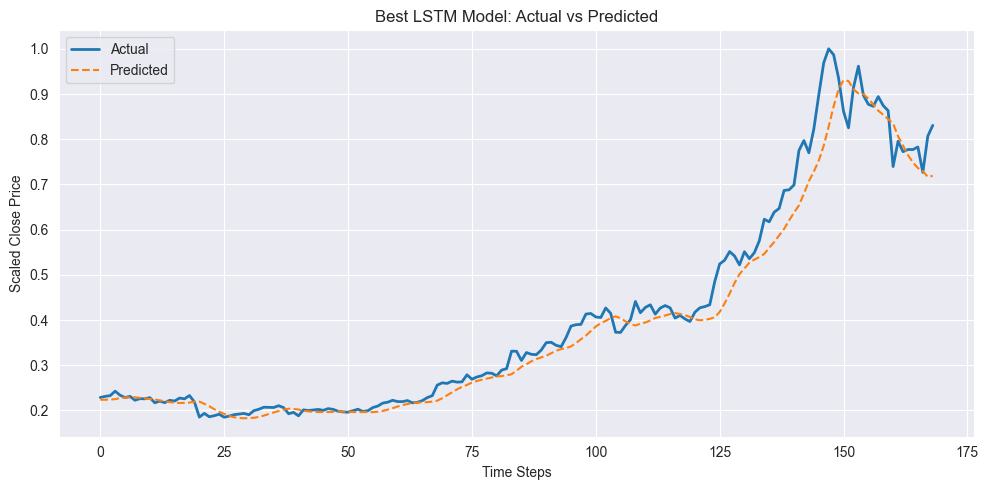

In [17]:
# Plot actual vs predicted
plt.figure(figsize=(10, 5))
plt.plot(testY, label='Actual', linewidth=2)
plt.plot(preds, label='Predicted', linestyle='--')
plt.title("Best LSTM Model: Actual vs Predicted")
plt.xlabel("Time Steps")
plt.ylabel("Scaled Close Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Evaluating LSTM Model Results

After testing several combinations of parameters, the best-performing LSTM model used the following settings:

- **Model type:** LSTM
- **Look-back window:** 30 days
- **Hidden units:** 64
- **Dropout rate:** 0.2
- **Validation MSE:** 0.001297

This means that the model performed best when using the past 30 days of Bitcoin prices to predict the next day's value. The low validation error indicates that it generalized well to data it hadn’t seen during training.

###  Performance by Look-back Window

The first plot shows how the model's performance changed depending on how many past days it looked at. Generally, the models with a shorter window of 10 days had the lowest and most consistent errors, though the best individual model overall came from a 30-day window.

This tells us that smaller windows are generally reliable, but longer windows may occasionally capture more complex trends when tuned correctly.

### Top Model Configurations

The second plot shows the 10 best configurations across all combinations. These are sorted by their validation error. You can see that the best-performing models used a mix of different look-back values, suggesting that model performance is sensitive to how far back I look, and tuning is essential.

### Actual vs Predicted Performance

In the final plot, I compare the model’s predictions (dashed orange line) to the actual Bitcoin prices (solid blue line). This was done on the testing set , data the model had never seen before.

The LSTM does a good job of tracking the general upward trend and turning points in the price, especially during large shifts in momentum. While it doesn’t match every single spike perfectly (which is expected), it shows strong alignment with the actual behavior, demonstrating the model's ability to learn meaningful temporal patterns in the data.

## RNN

In [18]:
set_seeds(42)

param_grid = {
    'look_back': [10, 20, 30],
    'units': [50, 64],
    'dropout': [0.2, 0.3]
}

rnn_results_df = run_grid_search(train, test, param_grid, build_model_fn=build_rnn_model, model_name="RNN")

C:\Users\isabe\PycharmProjects\GSB-545\downgradedenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\isabe\PycharmProjects\GSB-545\downgradedenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\isabe\PycharmProjects\GSB-545\downgradedenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\isabe\PycharmProjects\GSB-545\downgraded

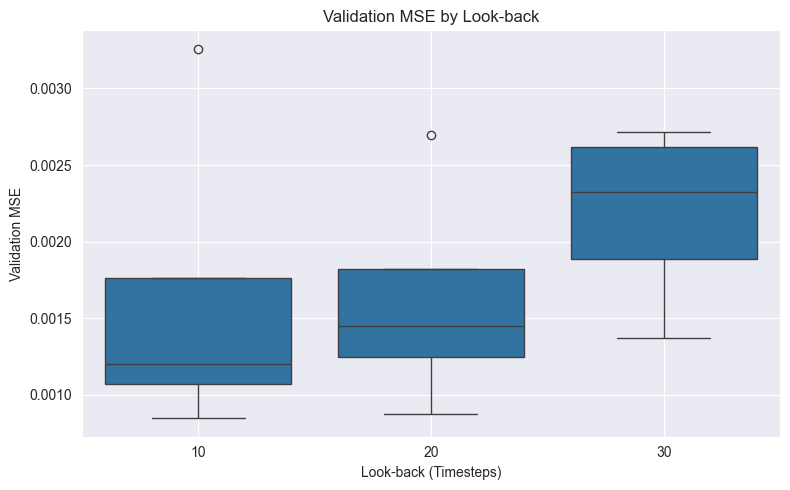

In [19]:
rnn_results_df = rnn_results_df.sort_values(by="val_mse")
plt.figure(figsize=(8, 5))
sns.boxplot(data=rnn_results_df, x='look_back', y='val_mse')
plt.title("Validation MSE by Look-back")
plt.xlabel("Look-back (Timesteps)")
plt.ylabel("Validation MSE")
plt.grid(True)
plt.tight_layout()
plt.show()

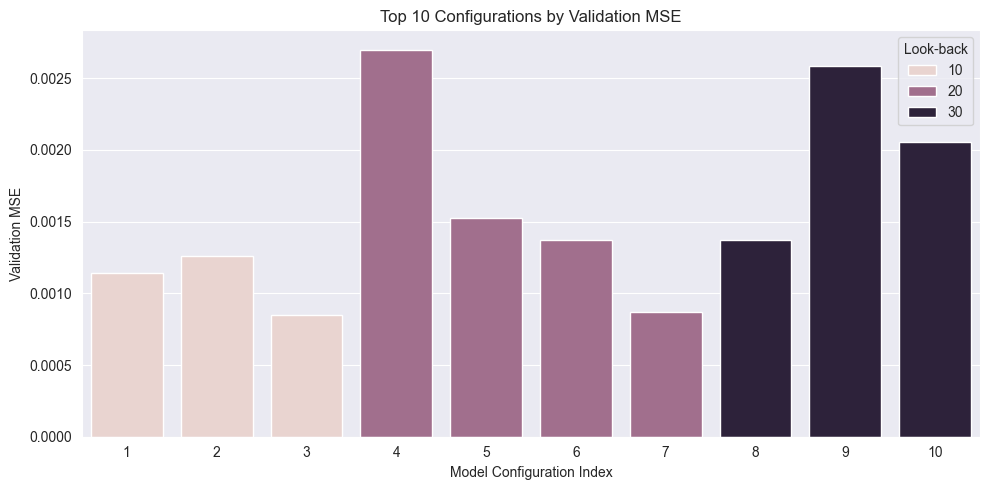

In [20]:
top10 = rnn_results_df.sort_values("val_mse").head(10)

plt.figure(figsize=(10, 5))
sns.barplot(data=top10, x=top10.index, y='val_mse', hue='look_back')
plt.title("Top 10 Configurations by Validation MSE")
plt.xlabel("Model Configuration Index")
plt.ylabel("Validation MSE")
plt.legend(title='Look-back')
plt.tight_layout()
plt.show()

In [21]:
best_config = rnn_results_df.sort_values(by='val_mse').iloc[0]
print("Best config:\n", best_config)

Best config:
 model             RNN
look_back          10
units              64
dropout           0.3
val_mse      0.000846
Name: 3, dtype: object


In [22]:
# Recreate dataset for best look_back
best_look_back = int(best_config['look_back'])
trainX, trainY = create_dataset(train, best_look_back)
testX, testY = create_dataset(test, best_look_back)

trainX = reshape_for_rnn(trainX)
testX = reshape_for_rnn(testX)

In [23]:
# Retrain the best model
best_model = build_rnn_model(
    input_shape=(best_look_back, 1),
    units=int(best_config['units']),
    dropout=float(best_config['dropout'])
)

best_model.fit(
    trainX, trainY,
    validation_data=(testX, testY),
    epochs=30,
    batch_size=32,
    verbose=0,
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)]
)

preds = best_model.predict(testX)

C:\Users\isabe\PycharmProjects\GSB-545\downgradedenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


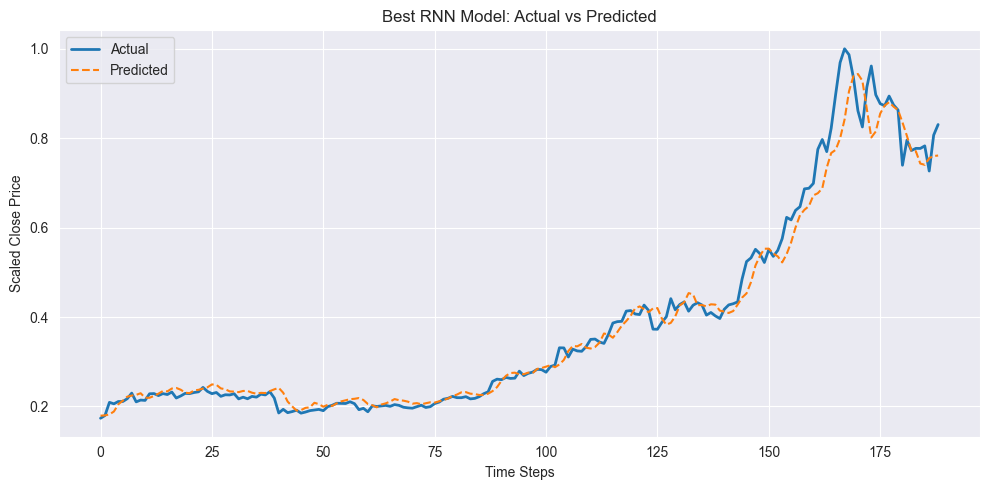

In [24]:
# Plot actual vs predicted
plt.figure(figsize=(10, 5))
plt.plot(testY, label='Actual', linewidth=2)
plt.plot(preds, label='Predicted', linestyle='--')
plt.title("Best RNN Model: Actual vs Predicted")
plt.xlabel("Time Steps")
plt.ylabel("Scaled Close Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Evaluating RNN Model Results

In addition to testing LSTM models, I also evaluated a simpler architecture: a Recurrent Neural Network (RNN). RNNs are designed to handle sequential data and are often used in time series forecasting. While less complex than LSTMs, they can still capture short-term trends effectively.

### RNN Performance by Look-back Window

The first plot shows how the RNN's performance varied depending on how many past days it considered when making a prediction. I tested look-back windows of 10, 20, and 30 days.

- Models using a 10-day window consistently performed well, showing lower and more stable error.
- As the window increased, performance became more variable and generally worse, likely due to the RNN's limited memory compared to LSTM models.

This suggests that RNNs are best used for shorter-term forecasting tasks where fewer time steps are needed to make accurate predictions.

### Top RNN Configurations

The second plot shows the top 10 RNN configurations that were tested. Most of the best-performing models used a 10-day look-back, reinforcing the idea that RNNs perform best when the input sequence is short and recent.

The overall best RNN model used:

- **Look-back window:** 10 days
- **Hidden units:** 64
- **Dropout rate:** 0.3
- **Validation MSE:** 0.000846

This model struck the best balance between memory capacity and regularization.

### Actual vs Predicted Performance

In the final plot, I compare the predictions made by the best RNN model (dashed orange line) to the actual Bitcoin prices (solid blue line). The RNN was able to follow the general direction of the price movement and responded well to upward and downward trends. While the predictions slightly lag during large price shifts, the model performs admirably given its simpler architecture. This makes RNNs a viable choice when computational efficiency or speed is more important than deep long-term learning.


## Conclusion

Through careful data preparation, model building, and hyperparameter tuning, I compared the performance of two popular time series models: the Simple RNN and the LSTM. Both models were able to capture meaningful patterns in Bitcoin’s price trends, with LSTMs generally performing better for longer-term memory and more complex sequences. However, RNNs also proved to be strong short-term predictors with lower computational complexity. Ultimately, the results highlight the importance of choosing the right architecture and tuning strategy for the forecasting task at hand , and show that deep learning can offer valuable insights even in volatile markets like cryptocurrency.